## Main Objective: 
The task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly.


## Data Understanding
train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.  
1. PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
2. HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
3. CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
4. Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
5. Destination - The planet the passenger will be debarking to.
6. Age - The age of the passenger.
7. VIP - Whether the passenger has paid for special VIP service during the voyage.
8. RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
9. Name - The first and last names of the passenger.
10. Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../dataset/train.csv")

#### What is the extent of missing values across each feature, and are there patterns to the missingness?
Understanding which columns have gaps and whether missingness correlates with other variables (e.g., CryoSleep passengers missing amenity data) will inform imputation strategies.

In [7]:
df.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [3]:
df.head(2)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True


In [8]:
df.isnull().mean() * 100

PassengerId     0.000000
HomePlanet      2.312205
CryoSleep       2.496261
Cabin           2.289198
Destination     2.093639
Age             2.059128
VIP             2.335212
RoomService     2.082135
FoodCourt       2.105142
ShoppingMall    2.392730
Spa             2.105142
VRDeck          2.162660
Name            2.300702
Transported     0.000000
dtype: float64

> The percentages help to decide whether imputation or dropping is reasonable (e.g., 2% vs 40%). It seems we should impute the missingness!  
No single column is overwhelmingly missing, so we won’t need to drop entire features. instead, we'll want smart imputation or indicator flags.


#### What is the distribution of HomePlanet values (Earth, Europa, Mars)? Is one dominant?
#### What percentage of total records is 201 missing values?

In [9]:
df['HomePlanet'].value_counts()

HomePlanet
Earth     4602
Europa    2131
Mars      1759
Name: count, dtype: int64

> Earth has 4602, Europa has 2131 and Mars has 1759 instances!  
The missing values percentage: HomePlanet = 2.312205!  

#### Is there a strong relationship between HomePlanet and Cabin deck? (e.g., do Europa passengers tend to stay on certain decks?)

In [10]:
# Passenger
df[['passenger_group', 'passenger_number_in_group']] = df['PassengerId'].str.split('_', expand=True)
df['passenger_group'] = df['passenger_group'].astype(int)
df['passenger_number_in_group'] = df['passenger_number_in_group'].astype(int)

# Cabin
df[['Deck', 'CabinNum', 'Side']] = df['Cabin'].str.split("/", expand=True)  
df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce')

In [11]:
pd.crosstab(df['HomePlanet'], df['Deck'], normalize='index')

Deck,A,B,C,D,E,F,G,T
HomePlanet,,,,,,,,
Earth,0.000000,0.000000,0.000000,0.000000,0.087641,0.358110,0.554249,0.000000
Europa,0.121739,0.370048,0.354589,0.089855,0.061836,0.000000,0.000000,0.001932
Mars,0.000000,0.000000,0.000000,0.163763,0.191638,0.644599,0.000000,0.000000


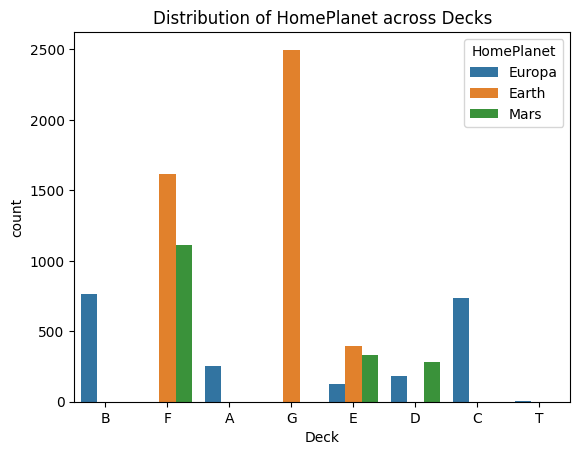

In [12]:
sns.countplot(data=df, x='Deck', hue='HomePlanet')
plt.title("Distribution of HomePlanet across Decks")
plt.show()

**Earth Passengers:**  
1. Almost entirely concentrated on Decks F (35.8%) and G (55.4%). (if a passenger is on Deck F or G, they are very likely from Earth.)!
2. Very few on other decks.

**Europa passengers:**
1. Spread across Decks B (37.0%), C (35.5%), A (12.2%), D (9.9%). (Europa passengers dominate the upper decks (A–D), not the lower ones.)!
2. Almost none on F or G.

**Mars passengers:**
1. Mostly on Deck F (64.5%), with some on Deck D (16.4%) and E (19.2%). (Mars passengers overlap with Earth on Deck F, but also appear on Deck E and D.)!
2. None on A–C.

#### Can we predict HomePlanet from the Cabin deck/side combination?

In [13]:
# Side Alone
pd.crosstab(df['HomePlanet'], df['Side'], normalize='index')

Side,P,S
HomePlanet,,
Earth,0.503661,0.496339
Europa,0.461353,0.538647
Mars,0.515679,0.484321


> Side alone is almost balanced. There’s no strong bias, differences are within ~5–6 percentage points. So if we only used Side to impute HomePlanet, we’d be guessing almost randomly!

In [14]:
df['DeckSide'] = df['Deck'] + "_" + df['Side']
pd.crosstab(df['HomePlanet'], df['DeckSide'], normalize='index')

DeckSide,A_P,A_S,B_P,B_S,C_P,C_S,D_P,D_S,E_P,E_S,F_P,F_S,G_P,G_S,T_P,T_S
HomePlanet,,,,,,,,,,,,,,,,
Earth,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.044154,0.043488,0.182827,0.175283,0.276681,0.277568,0.000000,0.000000
Europa,0.055556,0.066184,0.168116,0.201932,0.163285,0.191304,0.042995,0.046860,0.029952,0.031884,0.000000,0.000000,0.000000,0.000000,0.001449,0.000483
Mars,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.088850,0.074913,0.091754,0.099884,0.335075,0.309524,0.000000,0.000000,0.000000,0.000000


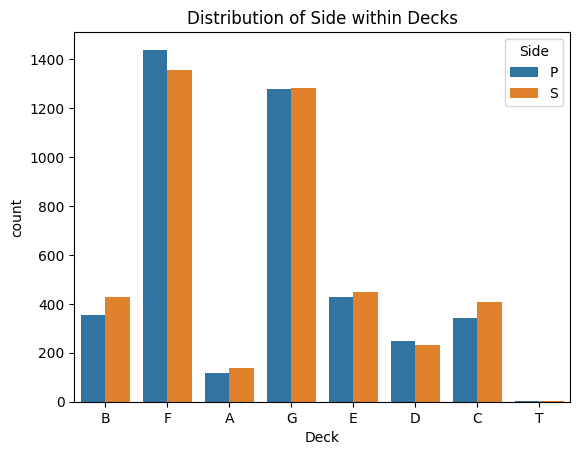

In [15]:
sns.countplot(data=df, x='Deck', hue='Side')
plt.title("Distribution of Side within Decks")
plt.show()

1. Deck is the strong predictor.
2. Side alone is weak — nearly balanced across planets.
3. Deck + Side combined doesn’t reveal new “absolute winners,” but can add small refinements in ambiguous decks (e.g., Mars passengers lean slightly Port on Deck F/E)!

#### For passengers with missing HomePlanet, do they have Cabin information we can leverage?

In [16]:
missing_hp = df[df['HomePlanet'].isna()]

In [17]:
# the proportion of missing Cabin among those with missing HomePlanet.
missing_hp['Cabin'].isna().mean()

0.029850746268656716

> Only ~3% of passengers with missing HomePlanet also lack Cabin info.

In [18]:
pd.crosstab(missing_hp['Deck'], missing_hp['Side'], normalize='index')

Side,P,S
Deck,,
A,0.500000,0.500000
B,0.384615,0.615385
C,0.230769,0.769231
D,0.600000,0.400000
E,0.434783,0.565217
F,0.528571,0.471429
G,0.475410,0.524590
T,1.000000,0.000000


1. Cabin is available for almost all missing HomePlanet cases
2. Deck T: 100% on Port side. This is unusual because Deck T is rare overall.
3. Deck A: Perfectly balanced between Port and Starboard. No bias.
4. Deck C: Skews toward Starboard (~77%).
5. Deck D/E/F/G: Roughly balanced, small tilts (e.g., Deck D leans Port, Deck E leans Starboard).
6. Side: adds small refinements (e.g., Deck C passengers lean Starboard), but not strong enough alone.

#### Is there a correlation between HomePlanet and Destination? (e.g., do Earth passengers prefer certain destinations?)

In [19]:
pd.crosstab(df['HomePlanet'], df['Destination'], normalize='index')

Destination,55 Cancri e,PSO J318.5-22,TRAPPIST-1e
HomePlanet,,,
Earth,0.153231,0.158117,0.688652
Europa,0.423114,0.009074,0.567813
Mars,0.112405,0.028538,0.859056


<Axes: xlabel='Destination', ylabel='count'>

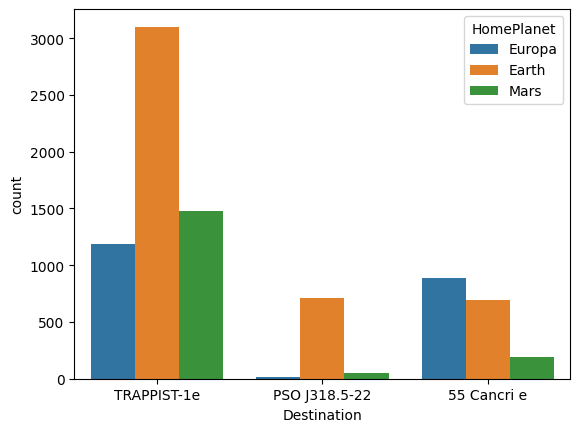

In [20]:
sns.countplot(data=df, x='Destination', hue='HomePlanet')

> If a passenger’s Destination is TRAPPIST‑1e, they are most likely from Earth or Mars.  
If Destination = 55 Cancri e, the passenger is most likely from Europa.  
If Destination = PSO J318.5‑22, the passenger is almost certainly from Earth.  


#### Do passengers in the same group (same gggg in PassengerId) share the same HomePlanet?

In [21]:
group_hp_counts = df.groupby('passenger_group')['HomePlanet'].nunique()

total_groups = group_hp_counts.shape[0]
single_hp_groups = (group_hp_counts == 1).sum()
multi_hp_groups = (group_hp_counts > 1).sum()
print("Single HP groups: ", single_hp_groups/total_groups)
print("Multi HP group: ", multi_hp_groups/total_groups)

Single HP groups:  0.9823065787357246
Multi HP group:  0.0


#### For passengers with missing HomePlanet, are there other group members with known HomePlanet?

In [22]:
missing_groups = df.loc[df['HomePlanet'].isna(), 'passenger_group'].unique()
group_has_known = df.groupby('passenger_group')['HomePlanet'].apply(lambda x: x.notna().any())
missing_group_info = group_has_known.loc[missing_groups]
prop_with_known = missing_group_info.mean()
print(f"Proportion of missing-HomePlanet groups with at least one known HomePlanet: {prop_with_known:.2f}")

Proportion of missing-HomePlanet groups with at least one known HomePlanet: 0.45


> 45% of groups with missing HomePlanet passengers also have at least one member with a known HomePlanet.   
For almost half of the missing cases, you can impute HomePlanet directly and confidently from another group member.   
The other 55% of missing cases are in groups where all members have HomePlanet missing (often single‑passenger groups or small groups with no filled values).  

#### Does HomePlanet correlate with CryoSleep usage rates?

In [23]:
pd.crosstab(df['HomePlanet'], df['CryoSleep'], normalize='index')

CryoSleep,False,True
HomePlanet,,
Earth,0.692068,0.307932
Europa,0.560540,0.439460
Mars,0.610140,0.389860


Earth
1. About 69% not in CryoSleep, 31% in CryoSleep.
2. Earth passengers are more likely to stay awake and use amenities.

Europa
1. About 56% not in CryoSleep, 44% in CryoSleep.
2. Europa passengers are the most balanced — they have the highest CryoSleep usage rate compared to Earth and Mars.

Mars

1. About 61% not in CryoSleep, 39% in CryoSleep.
2. Mars passengers are closer to Earth in behavior, but with slightly higher CryoSleep usage.

> There is a correlation between HomePlanet and CryoSleep, but it’s moderate rather than strong.  
Europa passengers are noticeably more likely to use CryoSleep than Earth or Mars.

#### Does HomePlanet correlate with VIP status?

In [24]:
pd.crosstab(df['HomePlanet'], df['VIP'], normalize='index')

VIP,False,True
HomePlanet,,
Earth,1.000000,0.000000
Europa,0.937291,0.062709
Mars,0.963287,0.036713


1. VIP status is extremely rare overall — almost everyone is non‑VIP.
2. Earth passengers never have VIP status, which is a strong categorical distinction.
3. Europa and Mars have a tiny fraction of VIP passengers, but the difference between them is small.

VIP status is not a strong predictor of HomePlanet because the rates are so low.  
However, it can be used as a rule‑out feature:    
1. If VIP=True → passenger cannot be from Earth (must be Europa or Mars).
2. If VIP=False → could be from any planet (Earth, Europa, Mars).

#### Does Age distribution differ significantly by HomePlanet?

<Axes: xlabel='Age', ylabel='Count'>

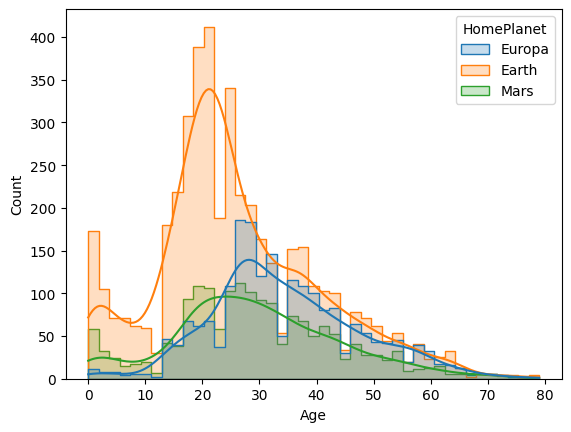

In [25]:
sns.histplot(data=df, x='Age', hue='HomePlanet', kde=True, element='step')

<Axes: xlabel='HomePlanet', ylabel='Age'>

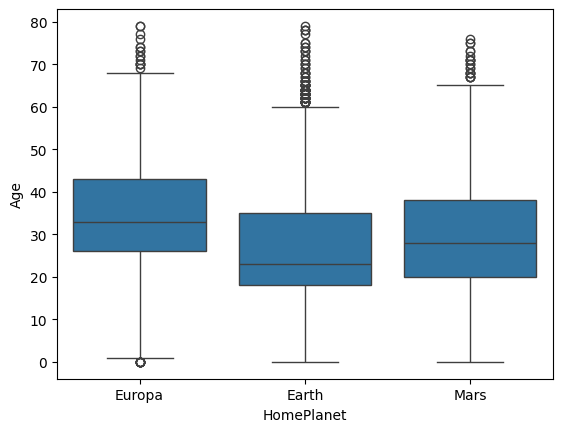

In [26]:
sns.boxplot(data=df, x='HomePlanet', y='Age')

1. The shapes of the Age distributions are nearly identical across Earth, Europa, and Mars.
2. The only difference is scale (counts): Earth has more passengers overall, so its histogram bars are taller, but the underlying distribution of ages looks the same.

> Age is not a strong predictor of HomePlanet.

#### Are there spending pattern differences across HomePlanets (amenity usage)?

In [27]:
df['total_spend'] = df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)

In [29]:
df.groupby('HomePlanet')['total_spend'].describe()

,count,mean,std,min,25%,50%,75%,max
HomePlanet,,,,,,,,
Earth,4602.0,673.337462,771.307925,0.0,0.0,704.0,888.0,6335.0
Europa,2131.0,3451.624589,4845.099433,0.0,0.0,1901.0,5346.0,35987.0
Mars,1759.0,1051.256964,1343.371706,0.0,0.0,946.0,1702.5,10801.0


---

#### Do passengers in the same group (same GroupId) tend to have the same CryoSleep status?

In [34]:
group_cs_counts = df.groupby('passenger_group')['CryoSleep'].nunique()
#group_cs_counts If the value is 1, all members of that group share the same CryoSleep status (all True or all False). If it’s >1, the group has mixed CryoSleep statuses.
total_groups = group_cs_counts.shape[0]
single_status_groups = (group_cs_counts == 1).sum()
multi_status_groups = (group_cs_counts > 1).sum()

print("Single CryoSleep groups:", single_status_groups / total_groups)
print("Multi CryoSleep groups:", multi_status_groups / total_groups)

Single CryoSleep groups: 0.8521795078011903
Multi CryoSleep groups: 0.1304487695029757


#### What percentage of missing CryoSleep cases have at least one group member with known CryoSleep status?

In [37]:
missing_cs = df[df['CryoSleep'].isna()]

# For each group, check if any member has CryoSleep filled
group_has_known = df.groupby('passenger_group')['CryoSleep'].apply(lambda x: x.notna().any())

missing_cs = df[df['CryoSleep'].isna()].copy()
missing_cs['group_has_known'] = missing_cs['passenger_group'].map(group_has_known)

# Proportion of missing CryoSleep passengers with at least one known group member
prop_with_known = missing_cs['group_has_known'].mean()
print(prop_with_known)

0.4976958525345622


#### What is the relationship between CryoSleep=True and spending on amenities (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck)?

In [39]:
df.loc[df['CryoSleep'] == True, 'total_spend'].value_counts()

total_spend
0.0    3037
Name: count, dtype: int64

1. All amenity spending (total_spending) = 0 → CryoSleep=True
2. Any amenity spending > 0 → CryoSleep=False

#### Are there passengers with CryoSleep=False who have all-zero spending?

In [45]:
df_cpy = df.copy()
df_cpy = df_cpy.dropna(subset=['CryoSleep'])
cs_false_zero_spending = df_cpy[(df_cpy['CryoSleep'] == False) & (df_cpy['total_spend'] == 0.0)]
cs_false_zero_spending.shape

(518, 21)

1. Spending=0 is a strong indicator of CryoSleep=True, but not 100% definitive because some CryoSleep=False passengers also spent nothing.
2. Spending>0 is a perfect indicator of CryoSleep=False.

#### Does Cabin_Deck correlate with CryoSleep status?
#### Does Cabin_Side (Port/Starboard) correlate with CryoSleep status?

In [47]:
pd.crosstab(df['Deck'], df['CryoSleep'], normalize='index')

CryoSleep,False,True
Deck,,
A,0.728000,0.272000
B,0.448684,0.551316
C,0.593923,0.406077
D,0.777778,0.222222
E,0.803738,0.196262
F,0.798239,0.201761
G,0.459135,0.540865
T,1.000000,0.000000


In [48]:
pd.crosstab(df['Side'], df['CryoSleep'], normalize='index')

CryoSleep,False,True
Side,,
P,0.653066,0.346934
S,0.634216,0.365784


Deck correlates with CryoSleep status — some decks are “CryoSleep-heavy” (B, G), others are “awake-heavy” (E, F, T). Deck is a useful predictor for imputing CryoSleep:
1. If passenger is on Deck B or G → higher chance of CryoSleep=True.
2. If passenger is on Deck E, F, or T → strong chance of CryoSleep=False.

Side is not useful — Port vs Starboard doesn’t add signal for CryoSleep.


#### What is the CryoSleep rate for each HomePlanet (Earth, Europa, Mars)?

In [49]:
pd.crosstab(df['HomePlanet'], df['CryoSleep'], normalize='index')

CryoSleep,False,True
HomePlanet,,
Earth,0.692068,0.307932
Europa,0.560540,0.439460
Mars,0.610140,0.389860


#### Does the destination planet (TRAPPIST-1e, 55 Cancri e, PSO J318.5-22) correlate with CryoSleep rates?

In [50]:
pd.crosstab(df['Destination'], df['CryoSleep'], normalize='index')

CryoSleep,False,True
Destination,,
55 Cancri e,0.579157,0.420843
PSO J318.5-22,0.507079,0.492921
TRAPPIST-1e,0.676149,0.323851


#### Do VIP passengers have different CryoSleep rates compared to non-VIP?

In [51]:
pd.crosstab(df['VIP'], df['CryoSleep'], normalize='index')

CryoSleep,False,True
VIP,,
False,0.636195,0.363805
True,0.892857,0.107143


#### What's the relationship between (HomePlanet + Destination) and CryoSleep?
#### What's the relationship between (HomePlanet + VIP) and CryoSleep?

In [52]:
df['HP_Dest'] = df['HomePlanet'].astype(str) + "_" + df['Destination'].astype(str)

pd.crosstab(df['HP_Dest'], df['CryoSleep'], normalize='index')

CryoSleep,False,True
HP_Dest,,
Earth_55 Cancri e,0.697194,0.302806
Earth_PSO J318.5-22,0.489209,0.510791
Earth_TRAPPIST-1e,0.731942,0.268058
Earth_nan,0.867347,0.132653
Europa_55 Cancri e,0.487805,0.512195
Europa_PSO J318.5-22,0.526316,0.473684
Europa_TRAPPIST-1e,0.613990,0.386010
Europa_nan,0.600000,0.400000
Mars_55 Cancri e,0.595745,0.404255


In [53]:
df['HP_VIP'] = df['HomePlanet'].astype(str) + "_" + df['VIP'].astype(str)

pd.crosstab(df['HP_VIP'], df['CryoSleep'], normalize='index')

CryoSleep,False,True
HP_VIP,,
Earth_False,0.693081,0.306919
Earth_nan,0.651376,0.348624
Europa_False,0.541776,0.458224
Europa_True,0.843750,0.156250
Europa_nan,0.547619,0.452381
Mars_False,0.595903,0.404097
Mars_True,1.000000,0.000000
Mars_nan,0.571429,0.428571
nan_False,0.612565,0.387435


1. Europa passengers are noticeably more likely to use CryoSleep compared to Earth and Mars. HomePlanet is moderately correlated with CryoSleep.
2. Destination strongly influences CryoSleep. PSO J318.5‑22 travelers are almost evenly split, while TRAPPIST‑1e travelers are mostly awake.
3. VIP passengers almost never use CryoSleep. Being VIP is a strong negative indicator for CryoSleep=True.
4. Combining HomePlanet with VIP strengthens the signal. VIP passengers from Mars are always awake, while Europa VIPs are almost always awake.

#### Do passengers in the same group tend to be in the same cabin?

In [ ]:
group_cabin_counts = df.groupby('passenger_group')['Cabin'].nunique()
#group_cabin_counts If the value is 1, all members of that group share the same CryoSleep status (all True or all False). If it’s >1, the group has mixed CryoSleep statuses.
total_groups = group_cabin_counts.shape[0]
single_status_groups = (group_cabin_counts == 1).sum()
multi_status_groups = (group_cabin_counts > 1).sum()

print("Single Cabin groups:", single_status_groups / total_groups)
print("Multi Cabin groups:", multi_status_groups / total_groups)

Single Cabin groups: 0.9163583722052436
Multi Cabin groups: 0.06771754865690847


In [58]:
missing_cabin = df[df['Cabin'].isna()]
group_has_known = df.groupby('passenger_group')['Cabin'].apply(lambda x: x.notna().any())
missing_cabin['group_has_known'] = missing_cabin['passenger_group'].map(group_has_known)
prop_with_known = missing_cabin['group_has_known'].mean()

C:\Users\Farhad\AppData\Local\Temp\ipykernel_29740\1206286245.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  missing_cabin['group_has_known'] = missing_cabin['passenger_group'].map(group_has_known)


In [60]:
def classify_group(group):
    decks = group['Deck'].nunique()
    sides = group['Side'].nunique()
    nums = group['CabinNum'].dropna().sort_values().tolist()
    
    if group['Cabin'].nunique() == 1:
        return "Same exact cabin"
    elif decks == 1 and sides == 1 and all(abs(nums[i+1]-nums[i]) <= 1 for i in range(len(nums)-1)):
        return "Same Deck+Side, sequential Num"
    elif decks == 1:
        return "Same Deck, different Num"
    else:
        return "Completely different cabins"

df.groupby('passenger_group').apply(classify_group).value_counts(normalize=True)


C:\Users\Farhad\AppData\Local\Temp\ipykernel_29740\439363801.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('passenger_group').apply(classify_group).value_counts(normalize=True)


Same exact cabin               0.916358
Completely different cabins    0.083642
Name: proportion, dtype: float64

In [61]:
df.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Transported,passenger_group,passenger_number_in_group,Deck,CabinNum,Side,DeckSide,total_spend,HP_Dest,HP_VIP
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,False,1,1,B,0.0,P,B_P,0.0,Europa_TRAPPIST-1e,Europa_False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,True,2,1,F,0.0,S,F_S,736.0,Earth_TRAPPIST-1e,Earth_False
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,False,3,1,A,0.0,S,A_S,10383.0,Europa_TRAPPIST-1e,Europa_True


---

In [78]:
#msno.matrix(df)
#plt.show()

> If the line is white across several columns, that passenger has missing values in multiple features.   
clusters of horizontal lines close together, that means several passengers in sequence (often from the same group/family, since PassengerId encodes groups) are missing similar sets of features.   
> These patterns are important because they hint at MAR (Missing At Random) rather than MCAR.  

In [79]:
#msno.heatmap(df)
#plt.show()

It’s a correlation matrix of missingness. Each cell measures how strongly the missingness of one feature is related to another.  
1. Positive correlation (close to +1): if column A is missing, column B is also often missing.
2. Zero correlation: missingness in A and B are independent.
3. Negative correlation: if A is missing, B is usually present.

HomePlanet, CryoSleep, Cabin, Destination, Age, VIP, These features tend to have missing values together. For example, if Cabin is missing, there’s a higher chance HomePlanet or VIP is missing too. That’s why they cluster positively.  
Other features showing negatives: That means when those features are missing, the “positive cluster” features are usually present.  

1. Structured missingness exists: HomePlanet, CryoSleep, Cabin, Destination, Age, VIP often go missing together.  
2. Independent missingness: Spending features (RoomService, FoodCourt)

#### Do passengers with missing values in one feature tend to have missing values in specific other features?
(Identify if there are "missing value clusters" — e.g., passengers missing HomePlanet also missing Cabin)

In [3]:
missing_matrix = df.isnull().astype(int)
# Computing pairwise correlations of missigness
missing_corr = missing_matrix.corr()

In [4]:
corr_pairs = (
    missing_corr.where(~np.eye(missing_corr.shape[0], dtype=bool))
    .stack()
    .sort_values(ascending=False)
)
print("Top correlated missingness pairs:\n", corr_pairs.head(10))

Top correlated missingness pairs:
 CryoSleep     Name            0.024627
Name          CryoSleep       0.024627
CryoSleep     ShoppingMall    0.013547
ShoppingMall  CryoSleep       0.013547
FoodCourt     Destination     0.012138
Destination   FoodCourt       0.012138
HomePlanet    Name            0.012128
Name          HomePlanet      0.012128
VRDeck        CryoSleep       0.011694
CryoSleep     VRDeck          0.011694
dtype: float64


> No strong dependencies: Missingness is mostly independent across features.  
Weak signals exist: CryoSleep ↔ amenities spending features show slight alignment, consistent with the story of cryosleep passengers not using services.  
Passengers with missing values in one feature do not strongly tend to have missing values in specific other features. The correlations are weak, though CryoSleep shows slight overlap with spending-related features!

#### Do passengers from the same group (same PassengerId prefix) have similar patterns of missingness?
(If families/groups share missing data patterns, group-based imputation could be powerful)

In [5]:
df[['passenger_group', 'passenger_number_in_group']] = df['PassengerId'].str.split('_', expand=True)
df['passenger_group'] = df['passenger_group'].astype(int)
df['passenger_number_in_group'] = df['passenger_number_in_group'].astype(int)

In [6]:
# 2. Add group info
missing_matrix['passenger_group'] = df['passenger_group']

# 3. Group-level missingness averages
group_missingness = missing_matrix.groupby('passenger_group').mean()

In [7]:
# proportion of groups with identical missingness patterns
def group_consistency(df, group_col):
    consistent = 0
    total = 0
    for g, sub in df.groupby(group_col):
        patterns = sub.drop(columns=[group_col]).drop_duplicates()
        if len(patterns) == 1:
            consistent += 1
        total += 1
    return consistent, total, consistent/total

consistent, total, ratio = group_consistency(missing_matrix, 'passenger_group')
print(f"Groups with identical missingness patterns: {consistent}/{total} ({ratio:.2%})")

Groups with identical missingness patterns: 5498/6217 (88.43%)


> Most groups have identical missingness patterns (88.43%), it suggests missingness is systematic at the group level (e.g., whole families missing HomePlanet)!  
88.43% of groups have identical missingness patterns 
→ This means that for the vast majority of passenger groups, either everyone in the group has the same features missing or no one has missing values!  
→ Missingness is highly consistent at the group level!  

#### For passengers missing Cabin information, can we predict their likely Deck/Side by looking at their HomePlanet, Destination, or group members' cabin assignments?
(Tests if cabin assignment follows logical patterns that enable rule-based imputation)

In [8]:
df[['Deck', 'CabinNum', 'Side']] = df['Cabin'].str.split("/", expand=True)  
df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce')

In [9]:
# Hypothesis: Passengers in the same passenger_group often share the same Cabin (or at least the same Deck and Side).

# Within each group, check if Deck/Side are consistent
group_cabin_consistency = df.groupby('passenger_group')[['Deck','Side']].nunique()

In [10]:
groups_with_diff_cabinInfo = group_cabin_consistency[(group_cabin_consistency['Deck'] > 1) | (group_cabin_consistency['Side'] > 1)]
groups_with_diff_cabinInfo_prc = round((len(groups_with_diff_cabinInfo) / len(group_cabin_consistency)) * 100, 2)
groups_with_diff_cabinInfo_prc

6.77

> 93.2% of groups are perfectly consistent: everyone in the group shares the same Deck and Side!  
6.8% of groups are inconsistent: at least one member differs in Deck or Side!  
This confirms that cabin assignment is highly structured at the group level — families/companions almost always stay together!  

In [11]:
# Distribution of Deck by HomePlanet
planet_deck = df.groupby('HomePlanet')['Deck'].value_counts(normalize=True).unstack().fillna(0)

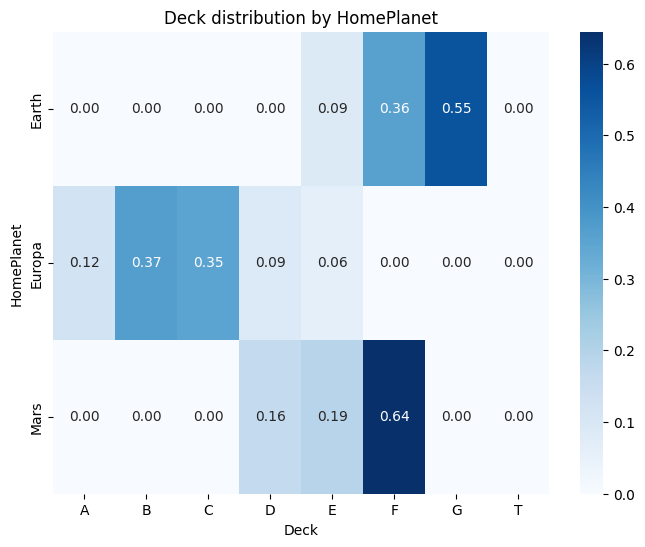

In [12]:
plt.figure(figsize=(8,6))
sns.heatmap(planet_deck, annot=True, cmap="Blues", fmt=".2f")
plt.title("Deck distribution by HomePlanet")
plt.show()

> Earth: Strong skew toward Deck F (36%) and G (55%). Very few on Deck E (9%). → If a passenger from Earth is missing Cabin info, you can confidently predict they’re most likely on Deck G or F.  
Mars: Strong skew toward Deck F (64%), with smaller proportions on D (16%) and E (19%). → Mars passengers missing Cabin info can often be imputed to Deck F.  
HomePlanet is a useful predictor for Deck. Earth and Mars show strong deck preferences, while Europa is more diffuse.

In [13]:
# Distribution of Side by Destination
dest_side = df.groupby('Destination')['Side'].value_counts(normalize=True).unstack().fillna(0)

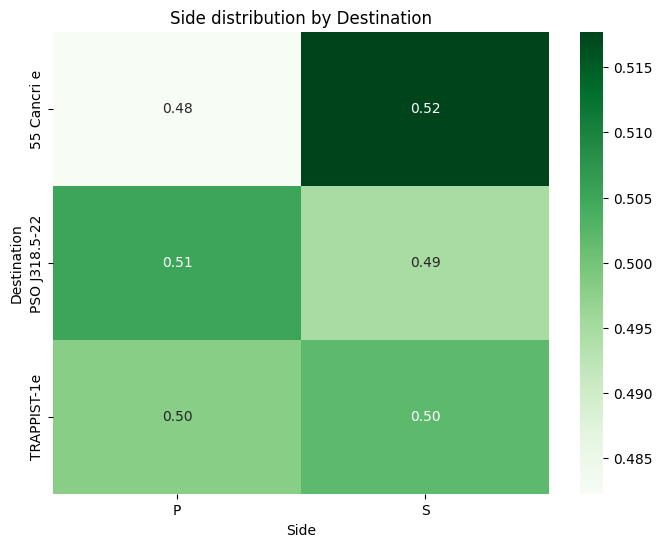

In [14]:
plt.figure(figsize=(8,6))
sns.heatmap(dest_side, annot=True, cmap="Greens", fmt=".2f")
plt.title("Side distribution by Destination")
plt.show()

> Destination does not predict Side. The distributions are essentially uniform — passengers are equally likely to be on Port or Starboard regardless of destination.

####  For passengers missing HomePlanet, do their last names (extracted from Name) cluster in ways that suggest planetary origin?
(Certain surnames might be Earth-specific vs Europa-specific, enabling surname-based imputation)

In [16]:
df['FirstName'] = df['Name'].apply(lambda x: x.split()[0] if pd.notna(x) else 'Unknown')
df['LastName'] = df['Name'].apply(lambda x: x.split()[-1] if pd.notna(x) else 'Unknown')

In [19]:
known_planet = df[df['HomePlanet'].notna()]

#Grouping by LastName and count HomePlanet distribution
surname_planet = known_planet.groupby('LastName')['HomePlanet'].value_counts(normalize=True).unstack().fillna(0)

In [21]:
surname_planet['max_share'] = surname_planet.max(axis=1)
strong_surnames = surname_planet[surname_planet['max_share'] > 0.8]

In [27]:
df.shape, known_planet.shape, strong_surnames.shape

((8693, 21), (8492, 21), (2209, 4))

> A surname is considered associated with a planet if at least 80% of passengers with that surname come from the same HomePlanet. Out of ~8,500 passengers with known HomePlanet, 2,209 surnames meet this criterion!

#### Do passengers with missing Age values have different distributions of other features (HomePlanet, Destination, spending patterns) compared to passengers with known Age?
(Determines if Age is Missing At Random (MAR) or Missing Not At Random (MNAR))

In [28]:
df['Age_missing'] = df['Age'].isna().astype(int)

In [29]:
# HomePlanet distribution by Age missingness
homeplanet_dist = df.groupby('Age_missing')['HomePlanet'].value_counts(normalize=True).unstack().fillna(0)
print(homeplanet_dist)

HomePlanet      Earth    Europa      Mars
Age_missing                              
0            0.542874  0.250752  0.206374
1            0.497175  0.259887  0.242938


Known Age (Age_missing=0):
1. Earth: 54.3%
2. Europa: 25.1%
3. Mars: 20.6%

Missing Age (Age_missing=1):
1. Earth: 49.7%
2. Europa: 26.0%
3. Mars: 24.3%

> Passengers with missing Age are less likely to be from Earth (drop from 54% → 50%).  
They are more likely to be from Mars (rise from 21% → 24%).  
Europa stays roughly the same.  
This suggests Age missingness is not completely random — it’s slightly associated with HomePlanet.  

In [30]:
# Destination distribution by Age missingness
destination_dist = df.groupby('Age_missing')['Destination'].value_counts(normalize=True).unstack().fillna(0)
print(destination_dist)

Destination  55 Cancri e  PSO J318.5-22  TRAPPIST-1e
Age_missing                                         
0               0.211878       0.093821     0.694301
1               0.193182       0.079545     0.727273


> Passengers with missing Age are slightly more likely to be going to TRAPPIST-1e (73% vs 69%).  
Slightly less likely to be going to 55 Cancri e or PSO J318.5-22.   
Again, this shows Age missingness is not random — it correlates weakly with Destination.

In [32]:
df.isnull().sum()

PassengerId                    0
HomePlanet                   201
CryoSleep                    217
Cabin                        199
Destination                  182
Age                          179
VIP                          203
RoomService                  181
FoodCourt                    183
ShoppingMall                 208
Spa                          183
VRDeck                       188
Name                         200
Transported                    0
passenger_group                0
passenger_number_in_group      0
Deck                         199
CabinNum                     199
Side                         199
FirstName                      0
LastName                       0
Age_missing                    0
dtype: int64

In [17]:
df.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,VRDeck,Name,Transported,passenger_group,passenger_number_in_group,Deck,CabinNum,Side,FirstName,LastName
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,Maham Ofracculy,False,1,1,B,0.0,P,Maham,Ofracculy
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,44.0,Juanna Vines,True,2,1,F,0.0,S,Juanna,Vines
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,49.0,Altark Susent,False,3,1,A,0.0,S,Altark,Susent


#### What are the distributions of numerical features (Age, RoomService, FoodCourt, ShoppingMall, Spa, VRDeck), and are there outliers or skewness that need addressing?
Highly skewed spending data or outliers could affect model performance and suggest transformations.

In [25]:
num_features = ["Age", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]

In [ ]:
fig, axes = plt.subplots(len(num_features), 2, figsize=(12, 4*len(num_features)))
for i, feature in enumerate(num_features):
    # Histogram with KDE
    sns.histplot(df[feature].dropna(), kde=True, ax=axes[i, 0], bins=30, color="skyblue")
    axes[i, 0].set_title(f"Distribution of {feature}")
    
    # Boxplot
    sns.boxplot(x=df[feature], ax=axes[i, 1], color="lightgreen")
    axes[i, 1].set_title(f"Boxplot of {feature}")

plt.tight_layout()
plt.show()

> Age is relatively well-behaved (Minor skewness, manageable outliers. Standardization or normalization is enough.)  
> Spending features are problematic for linear models (Extreme skewness + outliers can reduce performance. Transformations (like log(1+x)) help compress the long tail and reveal structure.)  

#### What is the class balance of the target variable (Transported)?
(Imbalanced classes would influence model selection, evaluation metrics, and potential resampling needs.)

In [27]:
df['Transported'].value_counts()

Transported
True     4378
False    4315
Name: count, dtype: int64

In [ ]:
sns.countplot(x='Transported', data=df, palette='autumn', hue='Transported')
plt.title('Distribution of Transported')
plt.xlabel('Transported True/False')
plt.ylabel('Count')
plt.ylim(4000, 4400)
plt.show()

#### How does the transportation rate vary by HomePlanet, and what is the distribution of passengers across planets? 
(This establishes whether origin planet is a strong predictor.)

In [29]:
# Distribution of passengers
planet_counts = df['HomePlanet'].value_counts()

# Transportation rate per planet
transportation_rate = df.groupby('HomePlanet')['Transported'].mean() * 100

In [ ]:
# Plot passenger distribution
plt.figure(figsize=(10, 5))
planet_counts.plot(kind='bar', color='skyblue')
plt.title('Passenger Distribution By HomePlanet')
plt.ylabel('Number of Passengers')
plt.show()

In [ ]:
# Plot Transportation rate
plt.figure(figsize=(10, 5))
transportation_rate.plot(kind='bar', color='lightgreen')
plt.title("Transportation Rate by HomePlanet")
plt.ylabel("Transported (%)")
plt.show()

> Earth has the largest group but the lowest transport rate!  
Europa has fewer passengers but the highest transport rate!  
This imbalance means the model must learn both distribution and rate. otherwise it might bias toward Earth simply because of volume!  


> Europa passengers are much more likely to be transported, even though they’re fewer in number.  
The fact that Europa passengers have a much higher transport rate suggests strong correlation between origin and outcome.  

> Europa passengers are more likely to be transported (~66%) compared to Earth (~42%) and Mars (~52%)!

####  Does CryoSleep status significantly correlate with being transported?
Given that CryoSleep passengers are confined to cabins, this could be a dominant feature.

In [32]:
transportation_rate_by_cryosleep = df.groupby('CryoSleep')['Transported'].mean() * 100
transportation_rate_by_cryosleep

CryoSleep
False    32.892076
True     81.758314
Name: Transported, dtype: float64

> CryoSleep = False (awake passengers): Only about 33% were transported. → Being awake seems to reduce the likelihood of being transported.  
CryoSleep = True (asleep in suspended animation): About 82% were transported. → Passengers in CryoSleep were far more likely to be transported.  

> CryoSleep status is strongly correlated with Transported. The difference is huge (almost 50 percentage points)!  
> if CryoSleep is True, passengers are much more likely to be transported!

#### How does Destination affect transportation probability?
Different destinations may have different risk profiles.

In [33]:
# Count how many passengers are going to each destination.
dest_counts = df["Destination"].value_counts()
dest_counts

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: count, dtype: int64

In [34]:
# Calculate the mean of Transported for each destination.
# Since Transported is True/False, the mean gives you the transportation probability (rate).
transportation_rate_by_dest = df.groupby('Destination')['Transported'].mean() * 100
transportation_rate_by_dest

Destination
55 Cancri e      61.000000
PSO J318.5-22    50.376884
TRAPPIST-1e      47.117498
Name: Transported, dtype: float64

**Passenger distribution**  
1. TRAPPIST‑1e: 5915 passengers (the majority group, ~5× larger than PSO J318.5‑22).   
2. 55 Cancri e: 1800 passengers.    
3. PSO J318.5‑22: 796 passengers (the smallest group).  
> **So** most of the dataset is dominated by TRAPPIST‑1e travelers.

**Transportation rates**
1. 55 Cancri e: ~61% transported (highest rate).  
2. PSO J318.5‑22: ~50% transported (about half).  
3. TRAPPIST‑1e: ~47% transported (lowest rate, despite being the largest group).  

> Passengers bound for "55 Cancri e" are much more likely to be transported compared to "TRAPPIST‑1e".  
> "TRAPPIST‑1e" dominates in passenger count but has the lowest transport rate.  
(If we train a model without care, it may bias toward "TRAPPIST‑1e" patterns simply because of volume.  
Balancing or weighting may be needed to ensure smaller groups (like PSO J318.5‑22) aren’t ignored.)

#### Does VIP status influence the likelihood of being transported?  
Tests whether premium service provides any "protection" or risk.

In [35]:
transportation_rate_by_VIP = df.groupby('VIP')['Transported'].mean() * 100
transportation_rate_by_VIP

VIP
False    50.633217
True     38.190955
Name: Transported, dtype: float64

In [36]:
df['VIP'].value_counts()

VIP
False    8291
True      199
Name: count, dtype: int64

**Passenger distribution**  
1. Non‑VIP: 8291 passengers (the overwhelming majority).
2. VIP: 199 passengers (tiny minority, ~2.3% of the dataset).
3. So the dataset is heavily imbalanced — most passengers are not VIPs.

**Transportation rates**  
1. Non‑VIP: ~50.6% transported.
2. VIP: ~38.2% transported.
3. This means VIP passengers were less likely to be transported compared to non‑VIPs.

> Being VIP actually correlates with a lower chance of being transported.  
VIP passengers may have had different cabin assignments or behaviors that reduced their transport likelihood.  
Yes, VIP status influences transport likelihood — VIPs were less likely to be transported (~38% vs ~51%).    
However, the VIP group is very small, so the effect should be interpreted with caution!  

#### Can we extract meaningful signals from the Cabin feature (deck, cabin number, port vs. starboard side)?
The deck, position on ship, and side could all carry spatial information about transport likelihood.

In [37]:
df[['Deck', 'CabinNum', 'Side']] = df['Cabin'].str.split("/", expand=True)  
df['CabinNum'] = pd.to_numeric(df['CabinNum'], errors='coerce')

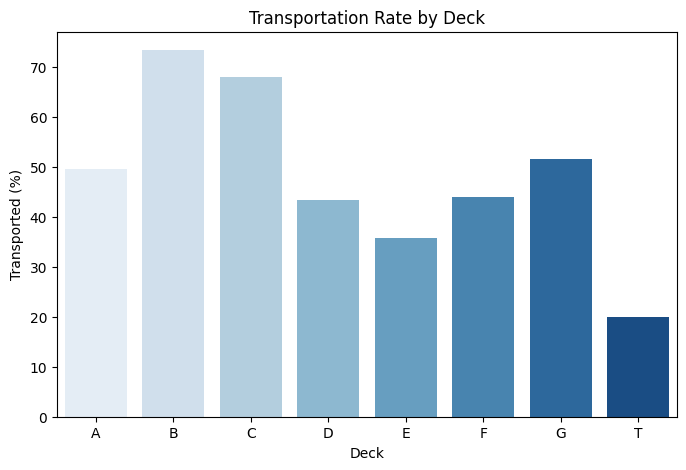

In [38]:
# --- Transport rate by Deck ---
transport_rate_deck = df.groupby('Deck')['Transported'].mean() * 100
plt.figure(figsize=(8,5))
sns.barplot(x=transport_rate_deck.index, y=transport_rate_deck.values, hue=transport_rate_deck.index,  palette="Blues")
plt.title("Transportation Rate by Deck")
plt.ylabel("Transported (%)")
plt.show()

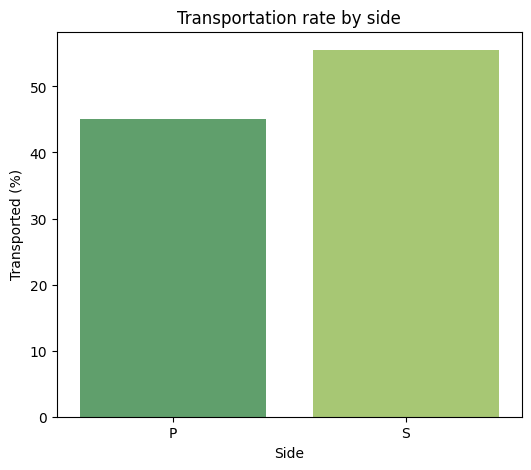

In [39]:
# --- Transport rate by Side --
transport_rate_side = df.groupby('Side')['Transported'].mean() * 100
plt.figure(figsize=(6, 5))
sns.barplot(x=transport_rate_side.index, y=transport_rate_side.values, hue=transport_rate_side.index, palette='summer')
plt.title("Transportation rate by side")
plt.ylabel("Transported (%)")
plt.show()

In [40]:
# --- Transport rate by CabinNum --- #
# We create bins to reduce noise and see broader patterns.
df['CabinNum_bin'] = pd.cut(df['CabinNum'], bins=20)  # divide into 20 bins

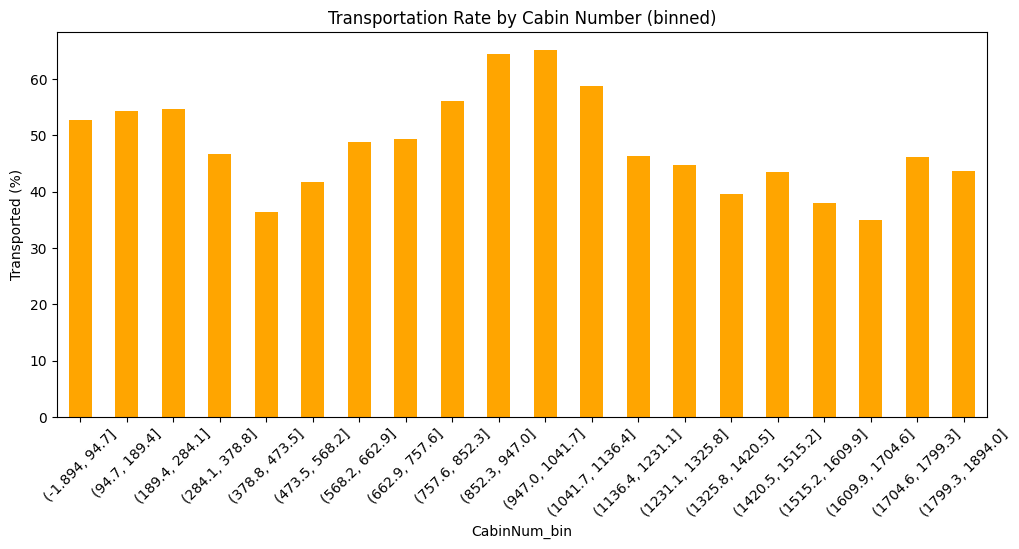

In [41]:
transport_rate_num = df.groupby('CabinNum_bin', observed=True)['Transported'].mean() * 100
plt.figure(figsize=(12,5))
transport_rate_num.plot(kind='bar', color="orange")
plt.title("Transportation Rate by Cabin Number (binned)")
plt.ylabel("Transported (%)")
plt.xticks(rotation=45)
plt.show()

1. Deck B (72%) and Deck C (67%) → highest transport rates.
2. Deck T (15%) → extremely low transport rate, stands out as an anomaly.
3. Other decks (A, G, F, D, E) hover between ~33–50%.
4. Deck location is strongly predictive.
5. Certain decks (B, C) were much more likely to be transported, while Deck T was almost excluded.
6. This suggests spatial clustering — where you were located on the ship mattered a lot.
7. Deck is the strongest predictor (clear differences in transport rates).
8. Side adds moderate predictive value.
9. CabinNum shows localized fluctuations, so binning or interactions may help.

#### Does the group structure in PassengerId (traveling alone vs. in groups, group size) correlate with transportation?
Family/group dynamics might affect outcomes.

In [42]:
# 1. PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. 
# People in a group are often family members, but not always
df[['passenger_group', 'passenger_number_in_group']] = df['PassengerId'].str.split('_', expand=True)
df['passenger_group'] = df['passenger_group'].astype(int)
df['passenger_number_in_group'] = df['passenger_number_in_group'].astype(int)

In [43]:
# group size
group_sizes = df.groupby('passenger_group').size().reset_index(name='group_size')
df = df.merge(group_sizes, on='passenger_group', how='left')

In [44]:
# Group transport rate
group_transport_rate = df.groupby('passenger_group')['Transported'].mean().reset_index(name='group_transport_rate')
df = df.merge(group_transport_rate, on='passenger_group', how='left')

In [45]:
group_consistency = df.groupby('passenger_group')['Transported'].nunique().reset_index(name='group_consistency')
df = df.merge(group_consistency, on='passenger_group', how='left')

Text(0.5, 1.0, 'Distribution of Group Transport Rates')

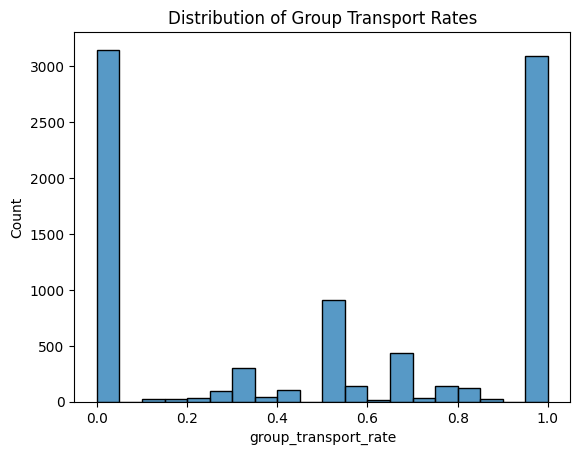

In [46]:
# Distribution of group transport rates
sns.histplot(df['group_transport_rate'], bins=20)
plt.title("Distribution of Group Transport Rates")

Text(0.5, 1.0, 'Transport Probability by Group Size')

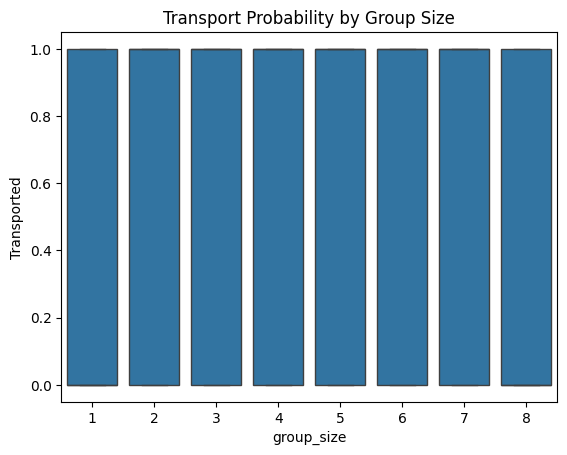

In [47]:
# Transport probability vs group size
sns.boxplot(x='group_size', y='Transported', data=df)
plt.title("Transport Probability by Group Size")

#### Solo vs. group travelers: Do solo passengers have different transport rates than those in groups?

In [48]:
group_size_transportation_rate = df.groupby('group_size')['Transported'].mean().reset_index()

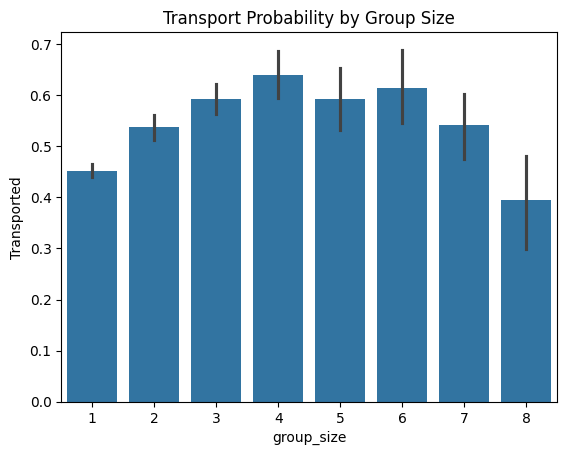

In [49]:
sns.barplot(x='group_size', y='Transported', data=df, estimator='mean')
plt.title("Transport Probability by Group Size")
plt.show()

Text(0.5, 1.0, 'Transport Probability by Group Size')

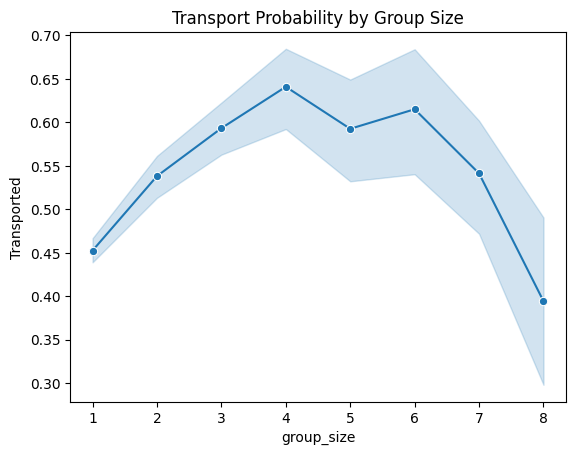

In [50]:
sns.lineplot(x='group_size', y='Transported', data=df, estimator='mean', marker='o')
plt.title("Transport Probability by Group Size")

**Interpretation**  
1. Solo travelers (group size = 1): Transport rate ≈ 0.45 → slightly below average.
2. Small groups (2–3): Around 0.52–0.55 → modestly higher than solos.
3. Medium groups (4–6): Highest transport rates (0.55–0.63), especially group size 4 (≈0.63) and 6 (≈0.60).
4. Large groups (7–8): Rates drop again (≈0.40–0.50), with group size 8 being the lowest.
5. Solo passengers seem less likely to be transported compared to those in small/medium groups.
6. Medium-sized groups (4–6) have the strongest chance of being transported together
7. Large groups (7–8) may be more heterogeneous (mixed outcomes), which lowers the average transport rate.

#### Is there a relationship between total spending (sum of all amenities) and being transported?
Could reveal whether activity level or wealth proxies affect outcomes.

In [51]:
df['total_spent'] = df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)

<Axes: xlabel='total_spent', ylabel='Density'>

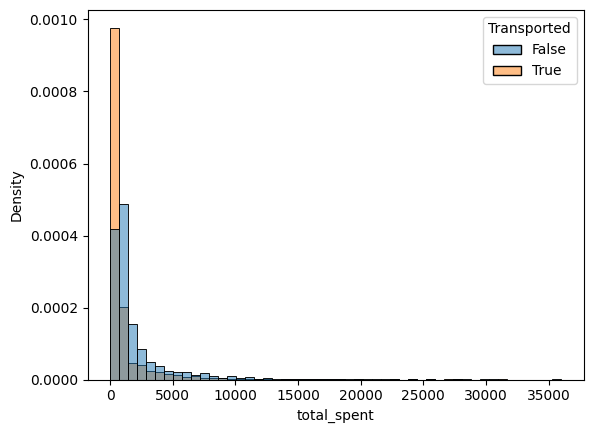

In [52]:
sns.histplot(data=df, x='total_spent', hue='Transported', bins=50, stat='density', common_norm=False)

In [53]:
# Step 2: Create bins (quartiles here, but you can adjust)
df['spend_category'] = pd.qcut(
    df['total_spent'], 
    q=4, 
    labels=['low','medium','high'], 
    duplicates='drop'
)

# Step 3: Calculate transport probability per category
spend_rates = df.groupby('spend_category')['Transported'].mean().reset_index()

C:\Users\Farhad\AppData\Local\Temp\ipykernel_31696\2992477759.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  spend_rates = df.groupby('spend_category')['Transported'].mean().reset_index()


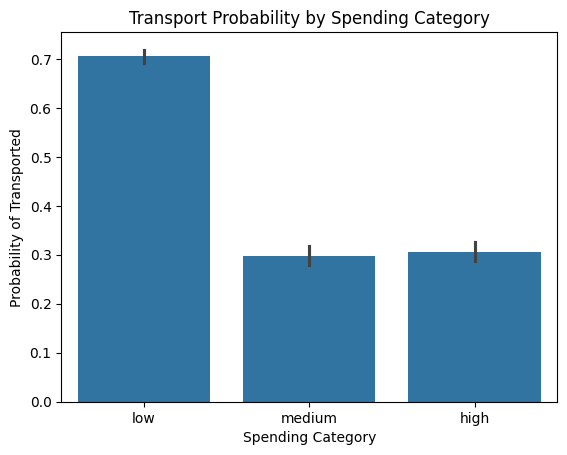

In [54]:
sns.barplot(x='spend_category', y='Transported', data=df, estimator='mean')
plt.title("Transport Probability by Spending Category")
plt.ylabel("Probability of Transported")
plt.xlabel("Spending Category")
plt.show()

> Passengers who spent nothing are much more likely to be transported. This makes sense because CryoSleep passengers almost always have zero spending (they don’t use amenities)  
Passengers who actively used amenities are much less likely to be transported. This suggests that being awake and active on the ship reduced the chance of transport! 
1. Zero spending ≈ CryoSleep → high transport probability.
2. Non-zero spending ≈ Awake → lower transport probability.

> Warning for multicollinearity between 'total_spent' and 'CryoSleep'!

####  Are passengers in CryoSleep showing zero spending across all amenities, and does this create multicollinearity?
This logical constraint could affect feature engineering and model interpretation.

In [55]:
# 3. CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
# Check if CryoSleep passengers spent anything
cryo_spending = df.loc[df['CryoSleep'] == True, ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']].sum(axis=1)

# Count how many CryoSleep passengers have non-zero spending
nonzero_cryo = (cryo_spending > 0).sum()
total_cryo = cryo_spending.shape[0]
print(f"Total CryoSleep passengers: {total_cryo}")
print(f"CryoSleep passengers with non-zero spending: {nonzero_cryo}")

Total CryoSleep passengers: 3037
CryoSleep passengers with non-zero spending: 0


In [56]:
# Correlation between CryoSleep and total_spent
df['CryoSleep_binary'] = df['CryoSleep'].dropna().astype(int)  # convert True/False to 1/0
corr = df[['CryoSleep_binary','total_spent']].corr()
print(corr)

                  CryoSleep_binary  total_spent
CryoSleep_binary          1.000000    -0.383115
total_spent              -0.383115     1.000000


#### How do Age and spending patterns interact—do younger/older passengers spend differently, and does this relate to transportation?
Age-spending interactions might be predictive.

In [57]:
df['age_bin'] = pd.cut(
    df['Age'],
    bins=[-1, 12, 18, 30, 50, 80],
    labels=['child', 'teen', 'young_adult', 'adult', 'senior']
)

In [58]:
df.groupby('age_bin')['total_spent'].mean()

C:\Users\Farhad\AppData\Local\Temp\ipykernel_31696\1511419835.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('age_bin')['total_spent'].mean()


age_bin
child             0.000000
teen            912.220963
young_adult    1404.752934
adult          2010.292820
senior         1903.819539
Name: total_spent, dtype: float64

Text(0.5, 1.0, 'Spending Patterns by Age Group')

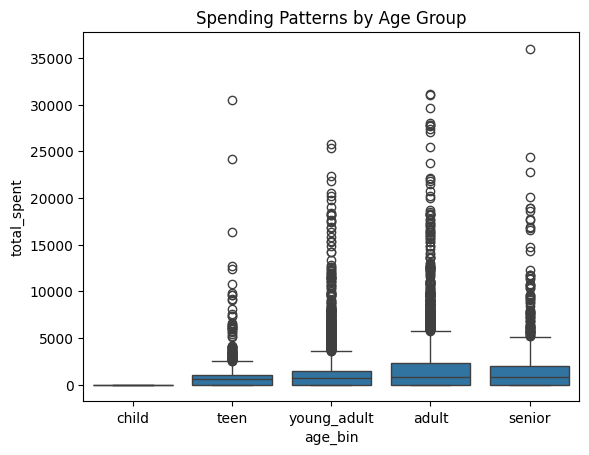

In [59]:
sns.boxplot(x='age_bin', y='total_spent', data=df)
plt.title("Spending Patterns by Age Group")

In [60]:
df.groupby('age_bin')['Transported'].mean()

C:\Users\Farhad\AppData\Local\Temp\ipykernel_31696\737478203.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby('age_bin')['Transported'].mean()


age_bin
child          0.699752
teen           0.537299
young_adult    0.468190
adult          0.479432
senior         0.484396
Name: Transported, dtype: float64

In [61]:
pd.crosstab(df['age_bin'], df['CryoSleep'], values=df['Transported'], aggfunc='mean')

CryoSleep,False,True
age_bin,,
child,0.682266,0.724138
teen,0.280072,0.836170
young_adult,0.309623,0.812127
adult,0.297205,0.846690
senior,0.300420,0.858921


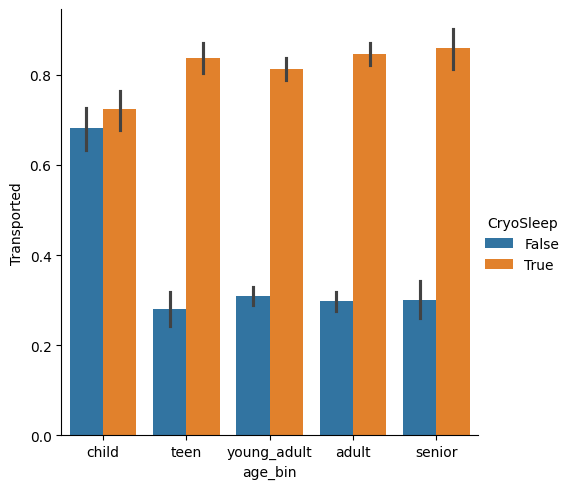

In [62]:
sns.catplot(x='age_bin', y='Transported', hue='CryoSleep', data=df, kind='bar', estimator='mean')

1. CryoSleep = True: Transport probability is very high across all age bins (≈0.81–0.86). → Being in CryoSleep is the dominant factor, regardless of age.
2. CryoSleep = False: Transport probability is much lower (≈0.28–0.68). → Awake passengers are less likely to be transported, but there’s variation:  
        1. Children (0.68): Even awake children have a relatively high transport rate compared to teens/adults.  
        2. Teens, young adults, adults, seniors (≈0.28–0.30): All much lower.  
3. Children are an exception: even awake, they have a higher transport rate (~0.68).
4. For older groups, awake passengers are consistently low (~0.28–0.30). → Age matters mostly when CryoSleep = False.
5. CryoSleep and Age interact.
6. Age modifies transport probability only when CryoSleep = False.
7. This is an interaction effect, not multicollinearity.

#### What correlations exist among the five amenity spending features?
High multicollinearity might suggest combining features or using regularization.

In [63]:
spending_features = ['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
corr_matrix = df[spending_features].corr()

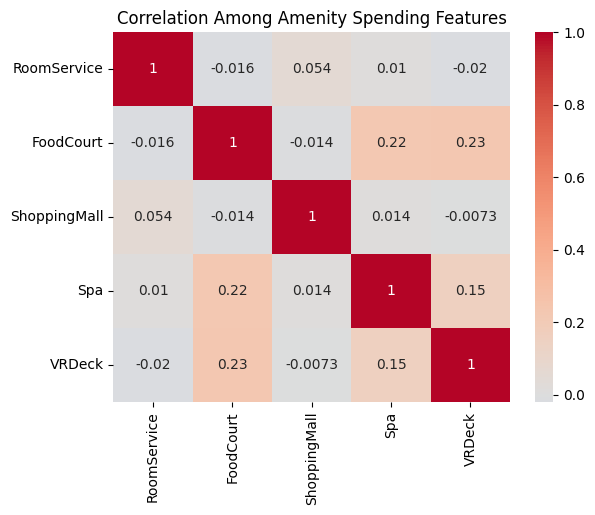

In [64]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Among Amenity Spending Features")
plt.show()

> The five amenity spending features (RoomService, FoodCourt, ShoppingMall, Spa, VRDeck) are not strongly correlated with each other.  
The highest correlations you found (≈0.22–0.23) are weak. This means passengers’ spending patterns are independent across amenities — someone who spends in the Spa doesn’t necessarily spend in the FoodCourt or VRDeck.

#### Are there clear linear separations in any feature with respect to the target, or do relationships appear non-linear?
Linear patterns favor logistic regression; complex boundaries suggest tree-based or ensemble methods.

In [67]:
# Define your numerical features
num_features = [
    'Age', 'total_spent', 'RoomService', 'FoodCourt',
    'ShoppingMall', 'Spa', 'VRDeck', 'group_size', 'CabinNum'
]

def plot_continuous_relationship(df, feature, bins=20):
    # Bin the feature into intervals
    df['bin'] = pd.cut(df[feature], bins=bins)
    
    # Calculate mean transport probability per bin
    rates = df.groupby('bin', observed=True)['Transported'].mean().reset_index()
    
    # Plot the curve
    sns.lineplot(x=rates['bin'].astype(str), y=rates['Transported'])
    plt.xticks(rotation=90)
    plt.title(f"Transport Probability vs {feature}")
    plt.show()

# Loop through all numerical features
#for feature in num_features:
    #plot_continuous_relationship(df, feature, bins=20)

> The numerical features do not show linear separations with respect to the target. Instead, they exhibit non-linear patterns (mountain-shaped, elbow-shaped, step-like). This indicates that logistic regression without transformations would struggle to capture the relationships.

In [66]:
df.head(3)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,passenger_group,passenger_number_in_group,group_size,group_transport_rate,group_consistency,total_spent,spend_category,CryoSleep_binary,age_bin,bin
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,1,1,1,0.0,1,0.0,low,0.0,adult,"(-1.894, 94.7]"
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,2,1,1,1.0,1,736.0,medium,0.0,young_adult,"(-1.894, 94.7]"
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,...,3,1,2,0.0,1,10383.0,high,0.0,senior,"(-1.894, 94.7]"
